The first thing we'll do is create a mapping of sequence IDs to their gene ontology (GO) terms stratified by their cooresponding subgraph of the gene ontology (sometimes referred to as "aspects").

In [108]:
from itertools import islice

import pandas as pd

from collections import defaultdict, Counter

terms_path = "./dataset/train/train_terms.tsv"

bp_seq_to_terms = defaultdict(list)
cc_seq_to_terms = defaultdict(list)
mf_seq_to_terms = defaultdict(list)
all_seq_to_terms = defaultdict(list)

bp_counter = Counter()
cc_counter = Counter()
mf_counter = Counter()
all_counter = Counter()

df = pd.read_csv(terms_path, sep='\t')

for _, row in df.iterrows():
    sequence_id = row["EntryID"]
    term_id = row["term"]

    match row["aspect"]:
        case "BPO":
            bp_seq_to_terms[sequence_id].append(term_id)
            bp_counter[term_id] += 1

        case "CCO":
            cc_seq_to_terms[sequence_id].append(term_id)
            cc_counter[term_id] += 1
            
        case "MFO":
            mf_seq_to_terms[sequence_id].append(term_id)
            mf_counter[term_id] += 1
    
    all_seq_to_terms[sequence_id].append(term_id)
    all_counter[term_id] += 1

bp_first_5 = dict(islice(bp_seq_to_terms.items(), 5))
cc_first_5 = dict(islice(cc_seq_to_terms.items(), 5))
mf_first_5 = dict(islice(mf_seq_to_terms.items(), 5))
all_first_5 = dict(islice(all_seq_to_terms.items(), 5))

for seq_to_term in [bp_first_5, cc_first_5, mf_first_5, all_first_5]:
    print("Example Sequence to Term Mappings")
    
    for sequence_id, term in seq_to_term.items():
        print(f"{sequence_id} => {term}")

print("\n")

bp_num_unique_terms = len(bp_seq_to_terms)
cc_num_unique_terms = len(cc_seq_to_terms)
mf_num_unique_terms = len(mf_seq_to_terms)
all_num_unique_terms = len(all_seq_to_terms)

print(f"BP Unique Terms: {bp_num_unique_terms:,}")
print(f"CC Unique Terms: {cc_num_unique_terms:,}")
print(f"MF Unique Terms: {mf_num_unique_terms:,}")
print(f"All Unique Terms: {all_num_unique_terms:,}")

Example Sequence to Term Mappings
A0A009IHW8 => ['GO:0008152', 'GO:0034655', 'GO:0072523', 'GO:0044270', 'GO:0006753', 'GO:1901292', 'GO:0044237', 'GO:1901360', 'GO:0008150', 'GO:1901564', 'GO:1901565', 'GO:0009117', 'GO:0006139', 'GO:0044281', 'GO:0046496', 'GO:0019362', 'GO:0046483', 'GO:0055086', 'GO:0044248', 'GO:0019439', 'GO:0019637', 'GO:0006807', 'GO:0019677', 'GO:1901361', 'GO:0006163', 'GO:0046700', 'GO:0009987', 'GO:0006725', 'GO:0006796', 'GO:0034641', 'GO:0072521', 'GO:0071704', 'GO:0019364', 'GO:1901575', 'GO:0072526', 'GO:0046434', 'GO:0009166', 'GO:0072524', 'GO:0006195', 'GO:0009056', 'GO:0044238', 'GO:0006793', 'GO:0019674']
A0A021WW32 => ['GO:0048869', 'GO:0048856', 'GO:0022008', 'GO:0065007', 'GO:0007275', 'GO:0007059', 'GO:0098813', 'GO:0042551', 'GO:0048518', 'GO:0008150', 'GO:1903047', 'GO:0007399', 'GO:0010604', 'GO:0050789', 'GO:0048468', 'GO:0019222', 'GO:0030154', 'GO:0000280', 'GO:0048469', 'GO:0000819', 'GO:0022402', 'GO:0048731', 'GO:0140014', 'GO:0007049'

Next thing we'll do is plot the top k GO terms for each subgraph using a bar chart. This will give us an idea for how skewed and imbalanced the CAFA 5 dataset is for each GO subgraph.

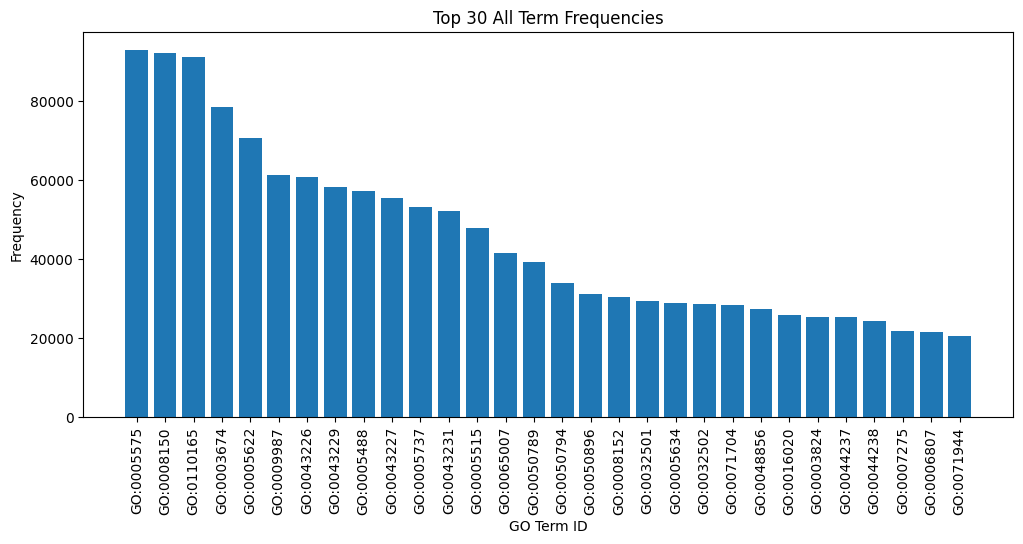

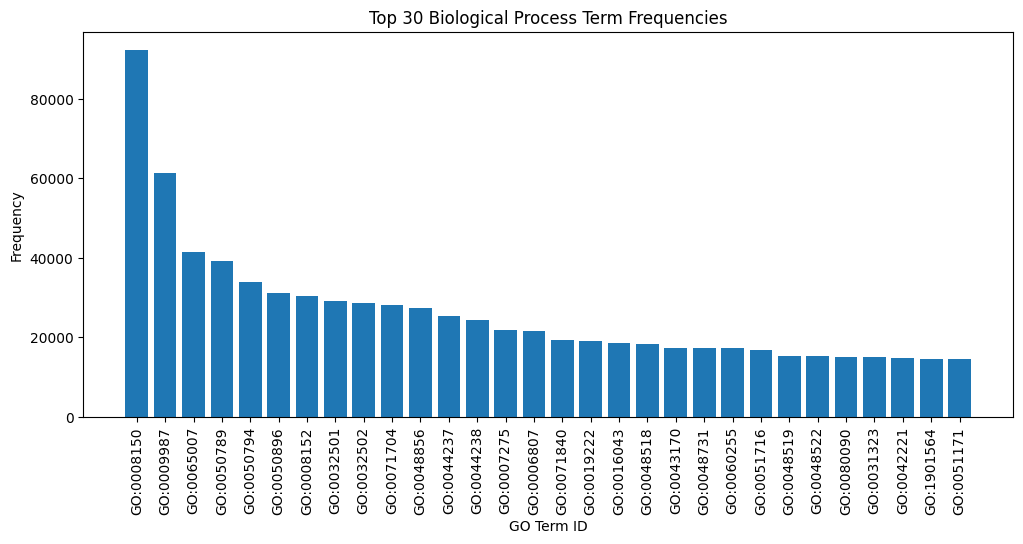

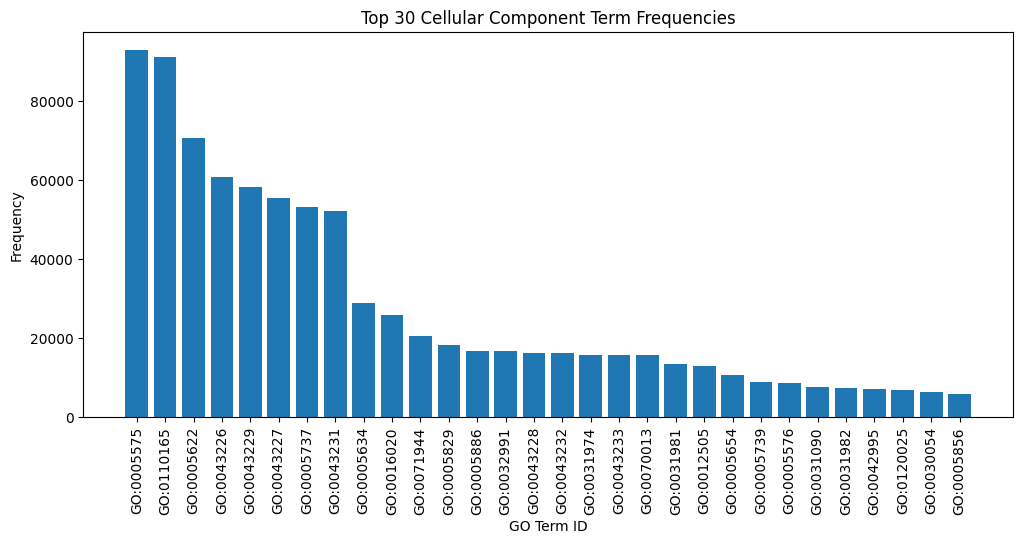

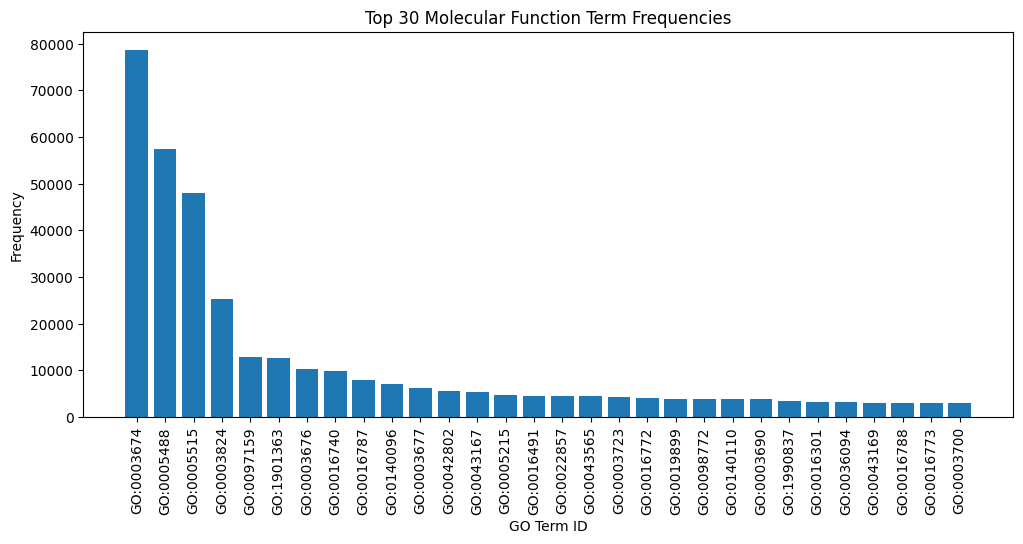

In [109]:
import matplotlib.pyplot as plt

top_k = 30

for name, counter in [
    ("All", all_counter),
    ("Biological Process", bp_counter),
    ("Cellular Component", cc_counter),
    ("Molecular Function", mf_counter),
]:
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

    first_k = dict(islice(counter.items(), top_k))

    plt.figure(figsize=(12, 5)) 

    plt.bar(first_k.keys(), first_k.values())

    plt.title(f"Top {top_k} {name} Term Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("GO Term ID")
    plt.ylabel("Frequency")

    plt.show()

Next, we'll map the sequence IDs to their corresponding NCBI taxon ID. You can search the taxonomy database at https://www.ncbi.nlm.nih.gov/taxonomy.

In [110]:
taxonomy_path = "./dataset/train/train_taxonomy.tsv"

seq_to_taxon_id = {}

taxon_id_counter = Counter()

df = pd.read_csv(taxonomy_path, sep='\t')

for _, row in df.iterrows():
    sequence_id = row["EntryID"]
    taxon_id = row["taxonomyID"]

    seq_to_taxon_id[sequence_id] = taxon_id
    taxon_id_counter[taxon_id] += 1

print(f"Number of unique taxon IDs: {len(taxon_id_counter):,}")

Number of unique taxon IDs: 3,156


Let's take a look at the distribution of the most common taxon IDs within the CAFA 5 dataset to determine how skewed and biased the data collection process was.

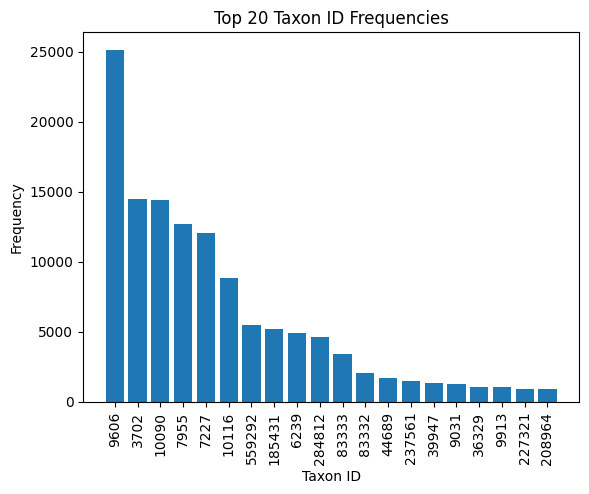

In [111]:
top_k = 20

taxon_id_count_tuples = taxon_id_counter.most_common(top_k)

taxon_ids, counts = zip(*taxon_id_count_tuples)

taxon_ids = [str(taxon_id) for taxon_id in taxon_ids]
counts = list(counts)

plt.bar(taxon_ids, counts)

plt.title(f"Top {top_k} Taxon ID Frequencies")
plt.xticks(rotation=90)
plt.xlabel("Taxon ID")
plt.ylabel("Frequency")

plt.show()

Next, let's create some embeddings for each sequence's GO subgraph. We'll use these embeddings later to aid in splitting the training and test sets. First, we'll create a k-hot vector for each sequence in the subset. Then, we'll create a dense embedding using SVD.

In [112]:
import numpy as np

from sklearn.decomposition import TruncatedSVD

min_explained_variance = 0.5

mf_label_embeddings = {}
bp_label_embeddings = {}
cc_label_embeddings = {}
all_label_embeddings = {}

for label_embeddings, sequence_to_terms, term_counter in [
    (mf_label_embeddings, mf_seq_to_terms, mf_counter),
    (cc_label_embeddings, cc_seq_to_terms, cc_counter),
    (bp_label_embeddings, bp_seq_to_terms, bp_counter),
    (all_label_embeddings, all_seq_to_terms, all_counter),
]:
    term_index_mapping = {term: index for index, term in enumerate(term_counter.keys())}

    for sequence_id, terms in sequence_to_terms.items():
        template = np.zeros(len(term_index_mapping), dtype=np.int8)

        for term in terms:
            if term in term_index_mapping:
                index = term_index_mapping[term]

                template[index] = 1

        label_embeddings[sequence_id] = template

    best_dimensionality = 0
    best_explained_variance = 0
    best_model = None

    for dimensionality in (16, 32, 48):
        svd = TruncatedSVD(n_components=dimensionality)

        x = np.stack(list(label_embeddings.values()))
        
        svd.fit(x)
        
        explained_variance = np.sum(svd.explained_variance_ratio_)

        if explained_variance > best_explained_variance:
            best_dimensionality = dimensionality
            best_explained_variance = explained_variance
            best_model = svd

        if explained_variance >= min_explained_variance:
            break

    print(f"Best dimensionality: {best_dimensionality}")
    print(f"Explained variance ratio: {best_explained_variance:.2f}")

    z = best_model.transform(x)

    for sequence_id, embedding in zip(label_embeddings.keys(), z):
        label_embeddings[sequence_id] = embedding

    first_5 = dict(islice(label_embeddings.items(), 5))

    print(f"Example embeddings:")

    for sequence_id, embedding in first_5.items():
        print(f"{sequence_id} => {embedding}")

    print("\n")

Best dimensionality: 32
Explained variance ratio: 0.59
Example embeddings:
A0A009IHW8 => [ 0.86211357  0.71828079  0.81424578  0.07648852 -0.34162296 -0.75714865
 -0.11997268 -0.06044321  0.19274495 -0.19208672  0.05466302 -0.1141327
  0.01822495 -0.03673294 -0.07222462 -0.15860361  0.08229075 -0.16183472
 -0.04941269  0.14283131 -0.00921892 -0.14482072 -0.24915465 -0.09793846
 -0.07830159  0.23287718  0.10509997 -0.08669453 -0.10981517  0.27269199
 -0.00964344 -0.10364726]
A0A023FBW4 => [ 1.58984275e+00  1.45978247e-01 -6.22263920e-01 -1.27651278e-01
 -2.81736322e-02 -2.19553031e-02  1.50260231e-02 -5.90374739e-02
 -1.07614897e-01 -8.53132950e-02 -3.97256347e-02 -1.25524484e-01
 -6.81191837e-02  2.56515467e-03 -2.79428436e-02 -3.88807473e-02
 -4.52978860e-02  6.25801330e-03 -9.54094553e-03 -5.31253520e-02
 -1.50365350e-02  1.06692397e-02 -5.68862230e-02 -1.88199988e-02
 -8.57500567e-03 -1.54939995e-02 -8.23672760e-03 -1.12740668e-02
  1.49730705e-03 -1.12381083e-03 -3.39430662e-03  1.

With the fresh embeddings, we'll cluster the sequences into strata of similar GO subgraphs.

In [113]:
from sklearn.cluster import KMeans

from functools import partial

mf_sequence_id_to_stratum = {}
bp_sequence_id_to_stratum = {}
cc_sequence_id_to_stratum = {}
all_sequence_id_to_stratum = {}

bp_stratum_counter = Counter()
cc_stratum_counter = Counter()
mf_stratum_counter = Counter()
all_stratum_counter = Counter()

new_kmeans = partial(KMeans, random_state=42)

for label_embeddings, sequence_id_to_stratum, stratum_counter in [
    (mf_label_embeddings, mf_sequence_id_to_stratum, mf_stratum_counter),
    (cc_label_embeddings, cc_sequence_id_to_stratum, cc_stratum_counter),
    (bp_label_embeddings, bp_sequence_id_to_stratum, bp_stratum_counter),
    (all_label_embeddings, all_sequence_id_to_stratum, all_stratum_counter),
]:
    kmeans = new_kmeans(n_clusters=100)

    x = np.stack(list(label_embeddings.values()))

    kmeans.fit(x)

    print(f"K-means steps: {kmeans.n_iter_}")
    print(f"Inertia Loss: {kmeans.inertia_}")

    strata_ids = kmeans.predict(x)

    for sequence_id, stratum_id in zip(label_embeddings.keys(), strata_ids):
        sequence_id_to_stratum[sequence_id] = stratum_id

        stratum_counter[stratum_id] += 1

    print(f"Number of unique strata: {len(stratum_counter):,}")

    first_5 = dict(islice(sequence_id_to_stratum.items(), 5))

    print(f"Example cluster assignments for {len(first_5)} sequences:")

    for sequence_id, stratum_id in first_5.items():
        print(f"{sequence_id} => {stratum_id}")

    print("\n")


K-means steps: 19
Inertia Loss: 33672.01818847213
Number of unique strata: 100
Example cluster assignments for 5 sequences:
A0A009IHW8 => 2
A0A023FBW4 => 1
A0A023FBW7 => 1
A0A023FDY8 => 1
A0A023FF81 => 1


K-means steps: 28
Inertia Loss: 41796.857972006204
Number of unique strata: 100
Example cluster assignments for 5 sequences:
A0A021WW32 => 16
A0A021WZA4 => 3
A0A023GPJ3 => 29
A0A023GUT0 => 24
A0A023IM54 => 25


K-means steps: 50
Inertia Loss: 528605.2925664274
Number of unique strata: 100
Example cluster assignments for 5 sequences:
A0A009IHW8 => 10
A0A021WW32 => 60
A0A023FFD0 => 47
A0A023GPJ3 => 3
A0A023GPK8 => 17


K-means steps: 98
Inertia Loss: 845626.3831989717
Number of unique strata: 100
Example cluster assignments for 5 sequences:
A0A009IHW8 => 27
A0A021WW32 => 36
A0A023FFD0 => 58
A0A023GPJ3 => 4
A0A023GPK8 => 5




Let's plot the stratum counts to visualize how they are distributed.

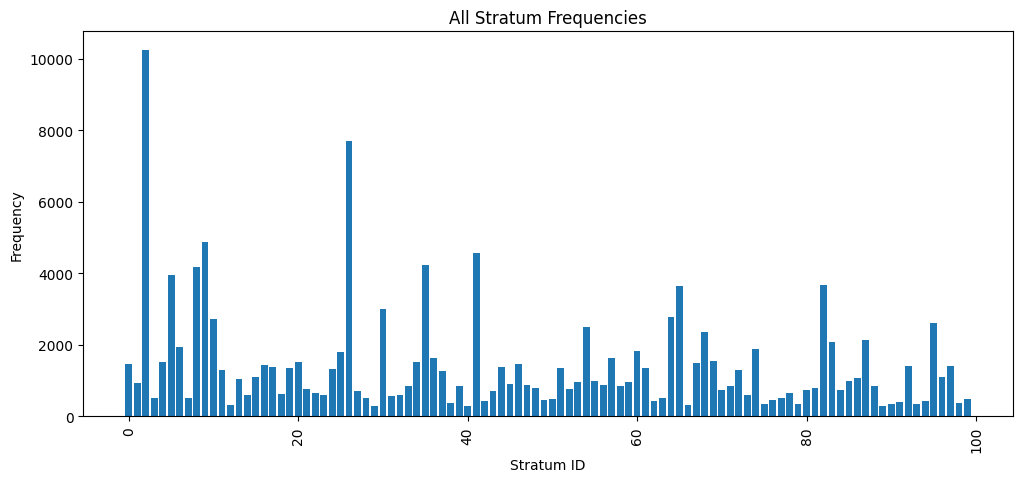

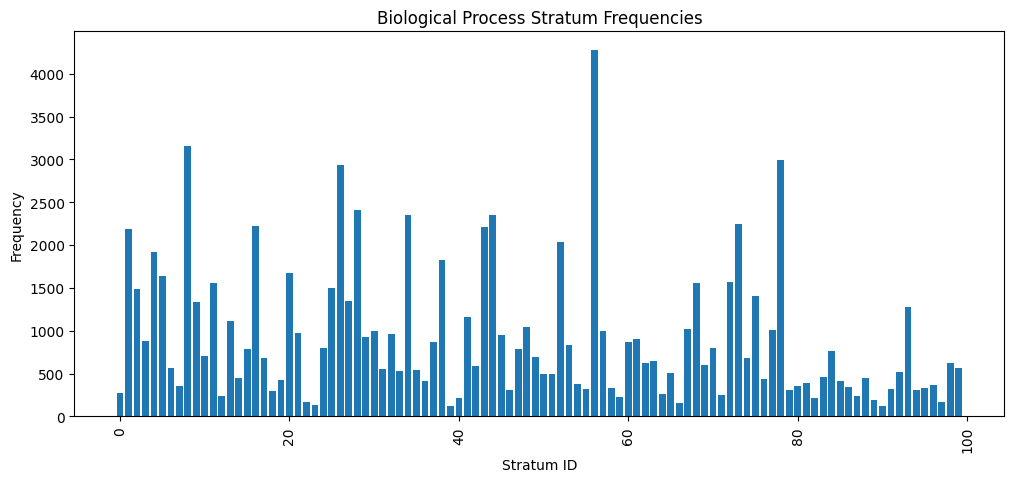

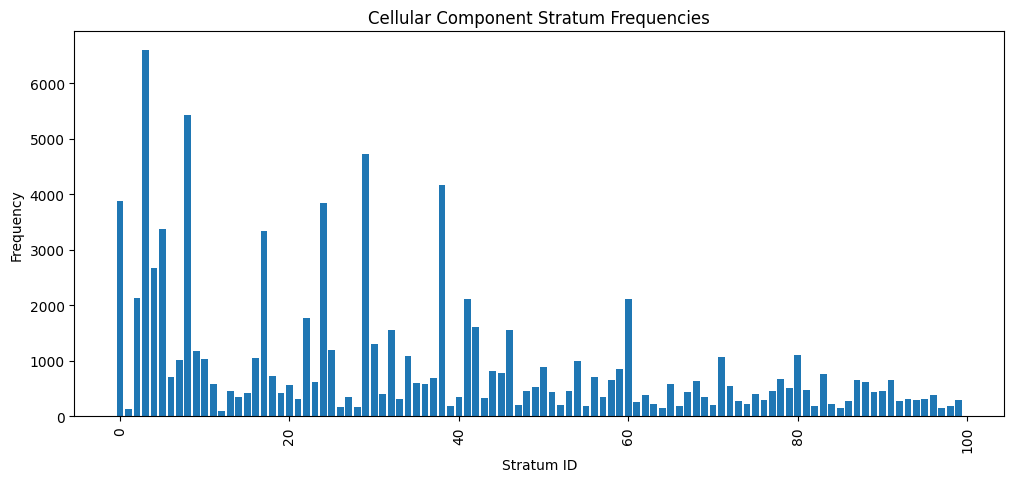

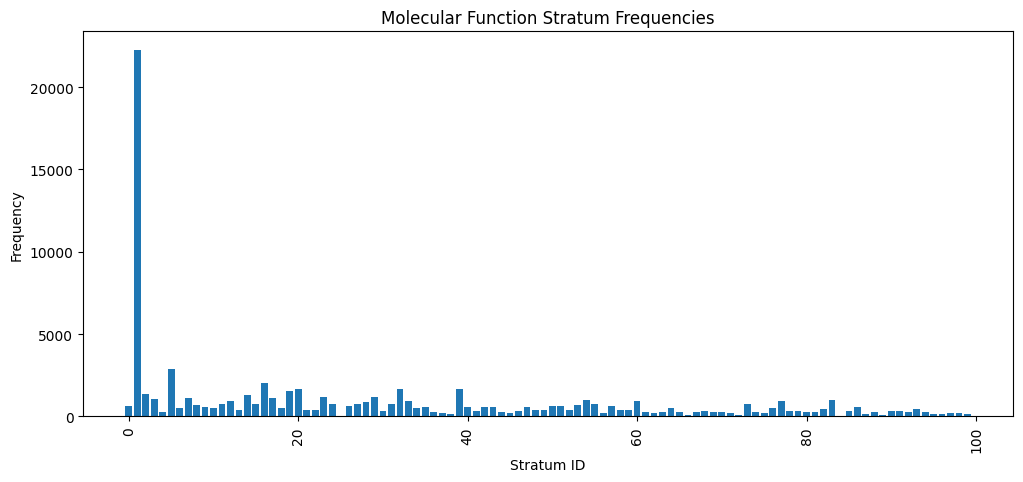

In [114]:
for name, counter in [
    ("All", all_stratum_counter),
    ("Biological Process", bp_stratum_counter),
    ("Cellular Component", cc_stratum_counter),
    ("Molecular Function", mf_stratum_counter),
]:
    plt.figure(figsize=(12, 5)) 

    plt.bar(counter.keys(), counter.values())

    plt.title(f"{name} Stratum Frequencies")
    plt.xticks(rotation=90)
    plt.xlabel("Stratum ID")
    plt.ylabel("Frequency")

    plt.show()

Now let's loop through the sequences provided in the Fasta file and associate their GO terms, term embeddings, taxon IDs, and stratum IDs.

In [115]:
import json

from Bio import SeqIO

fasta_path = "./dataset/train/train_sequences.fasta"

mf_dataset_path = "./dataset/mf.jsonl"
bp_dataset_path = "./dataset/bp.jsonl"
cc_dataset_path = "./dataset/cc.jsonl"
all_dataset_path = "./dataset/all.jsonl"

for dataset_path, sequence_to_terms, label_embeddings, sequence_id_to_stratum in [
    (mf_dataset_path, mf_seq_to_terms, mf_label_embeddings, mf_sequence_id_to_stratum),
    (cc_dataset_path, cc_seq_to_terms, cc_label_embeddings, cc_sequence_id_to_stratum),
    (bp_dataset_path, bp_seq_to_terms, bp_label_embeddings, bp_sequence_id_to_stratum),
    (all_dataset_path, all_seq_to_terms, all_label_embeddings, all_sequence_id_to_stratum),
]:
    with open(dataset_path, "w") as dataset_file:   
        with open(fasta_path, "r") as fasta_file:
            for record in SeqIO.parse(fasta_file, "fasta"):
                sequence_id = record.id

                terms = sequence_to_terms[sequence_id]

                if len(terms) == 0:
                    continue

                sequence = str(record.seq)

                seq_length = len(sequence)

                terms_embedding = label_embeddings[sequence_id]
                taxon_id = seq_to_taxon_id[sequence_id]
                stratum_id = sequence_id_to_stratum[sequence_id]

                line = {
                    "id": sequence_id,
                    "sequence": sequence,
                    "length": seq_length,
                    "terms": terms,
                    "terms_embedding": terms_embedding.tolist(),
                    "taxon_id": str(taxon_id),
                    "stratum_id": str(stratum_id),
                }

                dataset_file.write(json.dumps(line) + "\n")

    print(f"Dataset saved to {dataset_path}")

Dataset saved to ./dataset/mf.jsonl
Dataset saved to ./dataset/cc.jsonl
Dataset saved to ./dataset/bp.jsonl
Dataset saved to ./dataset/all.jsonl


Finally, let's create stratified train and test splits based on the `stratum_id` and upload the dataset to HuggingFace Hub.

In [116]:
from datasets import load_dataset

dataset_name = "andrewdalpino/CAFA5"

for dataset_path, subset_name in [
    (all_dataset_path, "all"),
    (mf_dataset_path, "mf"),
    (bp_dataset_path, "bp"),
    (cc_dataset_path, "cc"),
]:
    hf_dataset = load_dataset("json", data_files=dataset_path)

    hf_dataset = hf_dataset.class_encode_column("stratum_id")

    hf_dataset = hf_dataset["train"].train_test_split(test_size=0.1, stratify_by_column="stratum_id", seed=42)

    hf_dataset.push_to_hub(dataset_name, subset_name)

Generating train split: 142246 examples [00:00, 360819.27 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]
Generating train split: 78637 examples [00:00, 509966.53 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]
Generating train split: 92210 examples [00:00, 374636.53 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]
Generating train split: 92912 examples [00:00, 659723.27 examples/s]
Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]
